In [2]:
import openai
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

openai.api_key = os.environ['OPENAI_API_KEY']


In [57]:
def request_gpt(input_str) :

    chatgpt_sys_message = "You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence. The sequence is represented by decimal strings separated by commas."
    extra_input = "Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:\n"




    response = openai.ChatCompletion.create(
                model= "gpt-4-vision-preview",
                messages=[
                        {"role": "system", "content": chatgpt_sys_message},
                        {"role": "user", "content": extra_input + input_str}
                    ],
                temperature=1.0,
                n=1,
            )

    list_response = [choice.message.content for choice in response.choices]
    return list_response

def request_gpt_bin(input_str) :

    chatgpt_sys_message = "You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence. The sequence is represented by decimal strings separated by commas."
    extra_input = "Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the 7 following bin. Sequence:\n"
    gpt_bin_message = "The trend is represented by bins \"D5+\", \"D5\", \"D4\", \"D3\", \"D2\", \"D1\", \"U1\", \"U2\", \"U3\", \"U4\", \"U5\", \"U5+\", where \"D5+\" means price dropping more than 5%, D5 means price dropping between 4% and 5%, \"D4\" means price dropping between 3% and 4%, \"U5+\" means price rising more than 5%, \"U5\" means price rising between 4% and 5%, \"D4\" means price rising between 3% and 4%, etc."




    response = openai.ChatCompletion.create(
                model= "gpt-4-vision-preview",
                messages=[
                        {"role": "system", "content": chatgpt_sys_message},
                        {"role": "user", "content": gpt_bin_message + extra_input + input_str}
                    ],
                temperature=1.0,
                n=1,
            )

    list_response = [choice.message.content for choice in response.choices]
    return list_response

In [53]:
print(gpt_bin_message)

The trend is represented by bins "D5+", "D5", "D4", "D3", "D2", "D1", "U1", "U2", "U3", "U4", "U5", "U5+", where "D5+" means price dropping more than 5%, D5 means price dropping between 4% and 5%, "D4" means price dropping between 3% and 4%, "U5+" means price rising more than 5%, "U5" means price rising between 4% and 5%, "D4" means price rising between 3% and 4%, etc.


In [71]:
def str_convert(data) :
    final_str = ""
    for elt in data :
        str_number = str(round(elt))
        final_str = final_str + str_number + ", "
    return final_str


def plot_preds_candles(df, train, test, pred, model_name, show_samples=False, save_index = 0):

    save_folder = "./plot/" + str(save_index)
    index = len(train)

    opens = pd.Series(df['open'].values, index=df['date'])
    truth = pd.Series(df['close'].values, index=df['date'])
    highs = pd.Series(df['high'].values, index=df['date'])
    lows = pd.Series(df['low'].values, index=df['date'])

    plt.figure(figsize=(8, 6), dpi=100)

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')

    plt.bar(range(len(truth)), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)            

    plt.plot(range(index, index + len(pred[0])), pred[0], label=model_name, color='purple')
    
    index_to_display = range(0, len(truth), len(truth) // 3)
    truth.index = truth.index.date
    display_date = truth.index[index_to_display]
    plt.xticks(index_to_display, display_date)

    # plt.xticks(range(len(truth)), truth.index)
    # plt.grid()

    plt.savefig(save_folder)
    plt.show()


def get_data_set(name, input_length, start_date, end_date) :
    with open(name) as f:
        df = pd.read_csv(f, usecols=[0, 4], parse_dates=[0])
        mask = (df["date"] >= start_date) & (df["date"] <= end_date)
        df = df.loc[mask]
        df['close'] = df['close'].astype(float)
        series = pd.Series(df['close'].values, index=df['date'])

        f.seek(0)
        df_raw = pd.read_csv(f, parse_dates=[0])
        df_raw = df_raw.loc[mask]

        splitpoint = input_length
        train = series.iloc[:splitpoint]
        test = series.iloc[splitpoint:]

    return (df_raw, train, test)

def get_data_set_return(name, input_length, start_date, end_date) :
    with open(name) as f:
        df = pd.read_csv(f, usecols=[0, 1, 4], parse_dates=[0])
        mask = (df["date"] >= start_date) & (df["date"] <= end_date)
        df = df.loc[mask]
        df['close'] = df['close'].astype(float)
        df['open'] = df['open'].astype(float)
        df['return'] = ((df['close'] / df['open']) - 1) * 10000
        df = df[['date', 'return']]

        series = pd.Series(df['return'].values, index=df['date'])

        splitpoint = input_length
        train = series.iloc[:splitpoint]
        test = series.iloc[splitpoint:]

        f.seek(0)
        df_raw = pd.read_csv(f, parse_dates=[0])
        df_raw = df_raw.loc[mask]
        df_raw['close'] = df_raw['close'].astype(float)
        df_raw['open'] = df_raw['open'].astype(float)
        df_raw['return'] = ((df_raw['close'] / df_raw['open']) - 1) * 10000
        
    return (df_raw, train, test)


def basic_seriealize(list_response) :
    dic_int_list = []
    final_dic_int_list = []
    for elt in list_response :
        sub_chains = elt.split(',')
        int_list = [int(sub_chain.strip()) for sub_chain in sub_chains]

        dic_int_list.append(int_list)

    for elt in dic_int_list :
        if (len(elt) > 7) :
            new_elt = elt[:7]
        elif (len(elt) < 7) :
            last_numb = elt[-1]
            new_elt = elt
            while (len(new_elt) < 7) :
                new_elt.append(last_numb)
        final_dic_int_list.append(new_elt)
    return final_dic_int_list


['D1, U1, U2, D1, U1, U2, U3']

def bin_seriealize(list_response) :
    dic_int_list = []
    final_dic_int_list = []
    for elt in list_response :
        sub_chains = elt.split(',')
        for sub_chain in sub_chains :
            without_space = sub_chain.replace(" ", "")
            if (without_space == "U1") :
                dic_int_list.append(1)
            elif (without_space == "U2") :
                dic_int_list.append(2)
            elif (without_space == "U3") :
                dic_int_list.append(3)
            elif (without_space == "U4") :
                dic_int_list.append(4)
            elif (without_space == "U5") :
                dic_int_list.append(5)
            elif (without_space == "U5+") :
                dic_int_list.append(6)
            elif (without_space == "D1") :
                dic_int_list.append(-1)
            elif (without_space == "D2") :
                dic_int_list.append(-2)
            elif (without_space == "D3") :
                dic_int_list.append(-3)
            elif (without_space == "D4") :
                dic_int_list.append(-4)
            elif (without_space == "D5") :
                dic_int_list.append(-5)
            elif (without_space == "D5+") :
                dic_int_list.append(-6)
            else :
                print("error : ", without_space)

    return dic_int_list

def convert_bin_to_close(final_dic_int_list, df_raw, input_length) :
    final_dic = []
    col_index = df_raw.columns.get_loc('close')
    row_index = input_length - 1
    close = df_raw.iloc[row_index, col_index]
    memory = close
    for elt in final_dic_int_list :
        final_dic.append(int(memory * (1 + 0.01* elt)))
        memory = final_dic[-1]
    
    return [final_dic]
        
def convert_return_to_close(final_dic_int_list, df_raw, input_length) :
    final_dic = []
    col_index = df_raw.columns.get_loc('close')
    row_index = input_length - 1
    open = df_raw.iloc[row_index, col_index]
    memory = open
    for elt in final_dic_int_list[0] :
        final_dic.append(int((elt/10000 + 1) * memory))
        memory = final_dic[-1]
        
    return [final_dic]

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34591, 34756, 34706']
[[34591, 34756, 34706, 34706, 34706, 34706, 34706]]


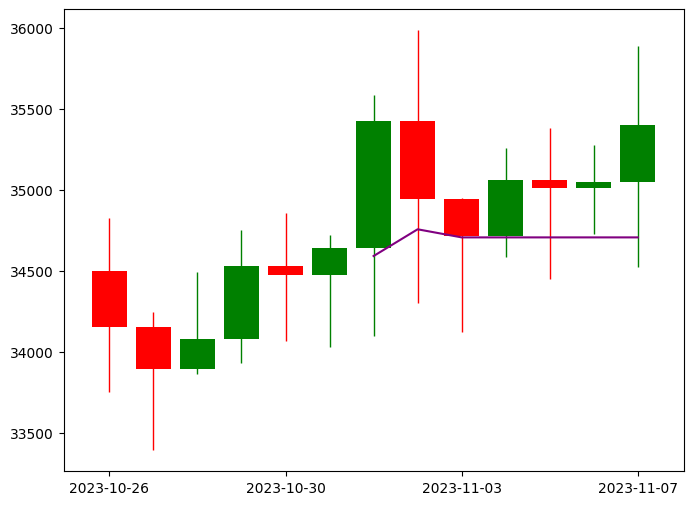

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34712, 34865, 34943']
[[34712, 34865, 34943, 34943, 34943, 34943, 34943]]


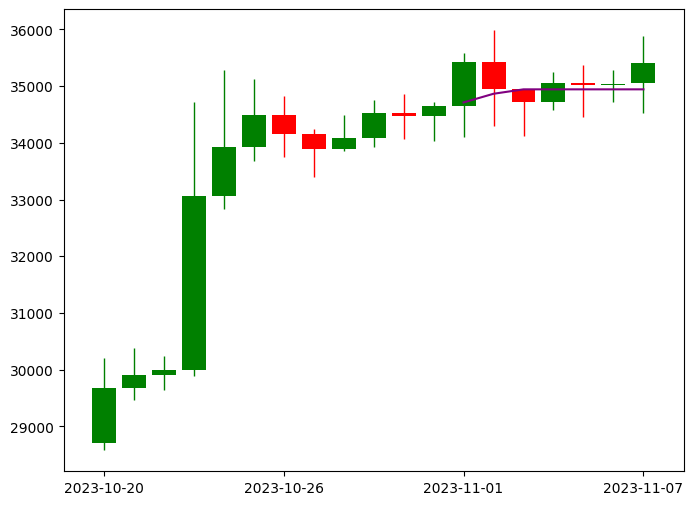

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34672']
[[34672, 34672, 34672, 34672, 34672, 34672, 34672]]


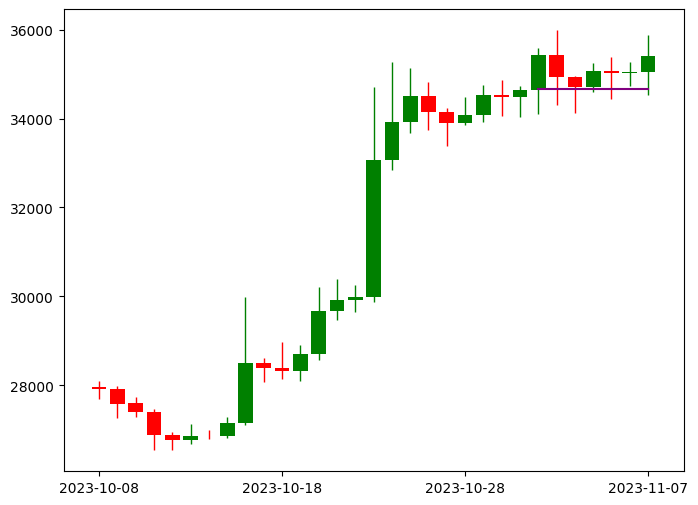

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34660, 34735, 34819']
[[34660, 34735, 34819, 34819, 34819, 34819, 34819]]


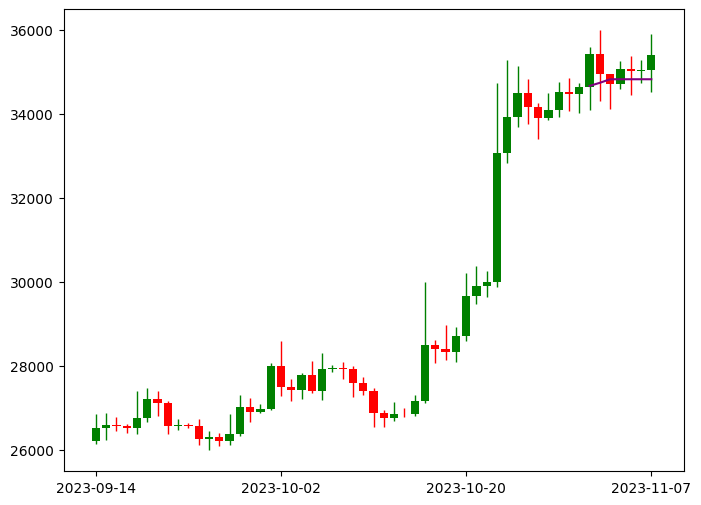

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34794, 34898']
[[34794, 34898, 34898, 34898, 34898, 34898, 34898]]


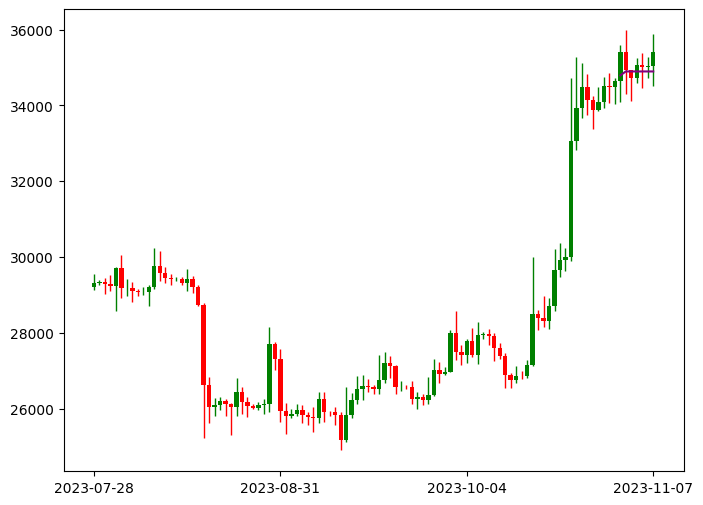

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

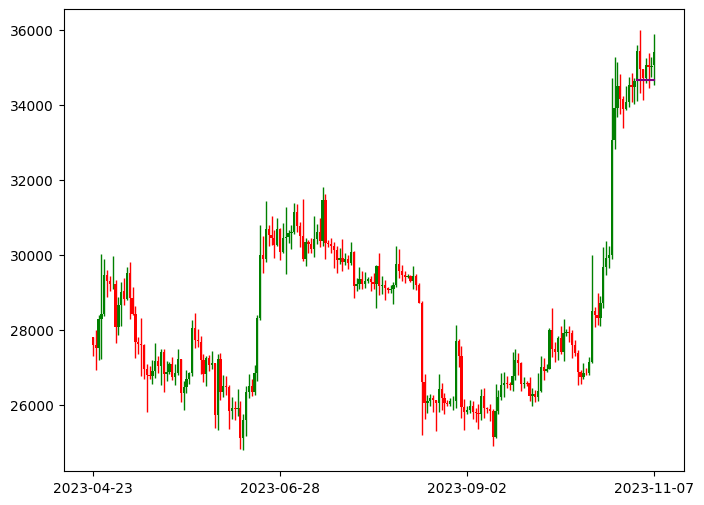

In [12]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0


for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = basic_seriealize(list_response)

    print(final_dic_int_list)

    index_save += 1
    plot_preds_candles(df_raw, train, test, final_dic_int_list, "gpt-4-vision-preview", show_samples=False, save_index = index_save)




Input str :  -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-312, 435, -260']
int list return
[[-312, 435, -260, -260, -260, -260, -260]]
int list, close
[[33399, 34851, 33944, 33061, 32201, 31363, 30547]]


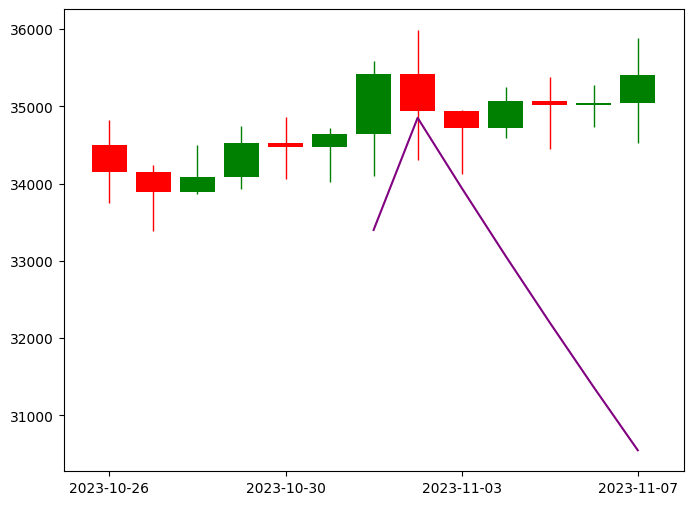

Input str :  333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['Without knowing the logic or pattern behind the provided sequence, it is mathematically impossible to predict its continuation with certainty. Generating a sequence continuation requires identifying the rule or function that generates the sequence. Since the sequence does not follow any immediately recognizable arithmetic, geometric, or other common mathematical progression, more information or context is needed to make a reliable prediction. If you can provide more details or specify the pattern rule, I can then assist you further.']
Input str :  -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-31, -49, 90, 168, -3']
int list return
[[-31, -49, 90, 168, -3, -3, -3]]
int list, close
[[34368, 34199, 34506, 35085, 35074, 35063, 35052]]


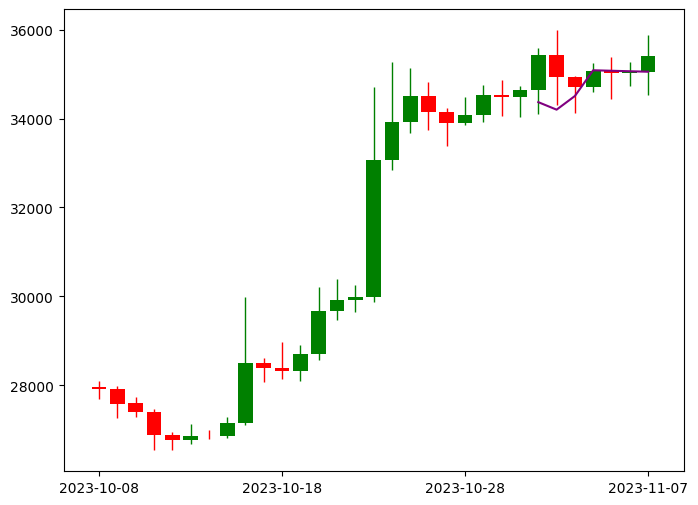

Input str :  115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['Based on the given sequence, it is impossible to determine a single logical pattern due to the random nature of the numbers. Without additional context or a rule governing the changes in the sequence, I am unable to make an accurate prediction of the subsequent terms.']
Input str :  31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -

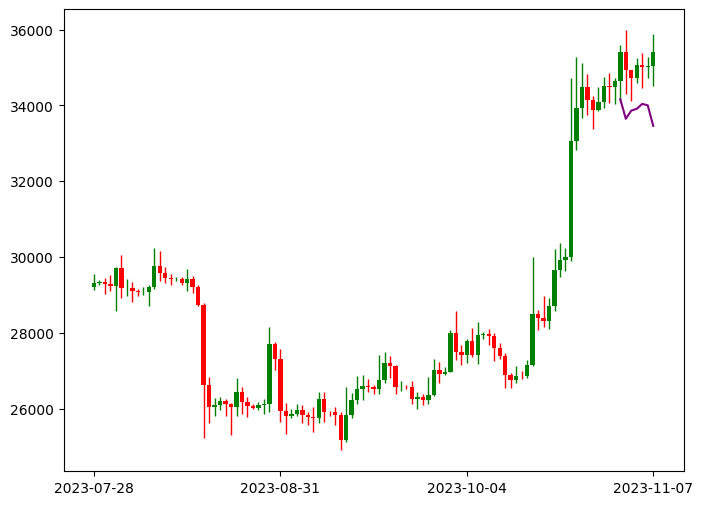

Input str :  -81, -29, 287, 41, 372, -55, -28, 1, -399, 214, 124, -65, 232, -222, -145, -268, -15, -11, -228, -64, -8, 53, 91, -47, 137, -213, 22, 83, -131, 38, 138, -327, 55, 88, 56, 451, -117, -15, -175, -144, 158, -64, 17, -511, 584, -327, 61, -8, -240, 33, -8, 11, -311, 187, 292, 65, -67, 192, 545, 596, -37, 269, -52, -21, -64, 140, -200, 123, 8, 37, 10, 176, -125, -85, -199, 150, -20, -41, 83, 69, -79, 354, -363, -7, -19, -31, -92, 17, -37, 34, -36, 97, -302, 18, 42, -44, 31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-13, 69, -114, -90, 84, 8, 47, -218, 30

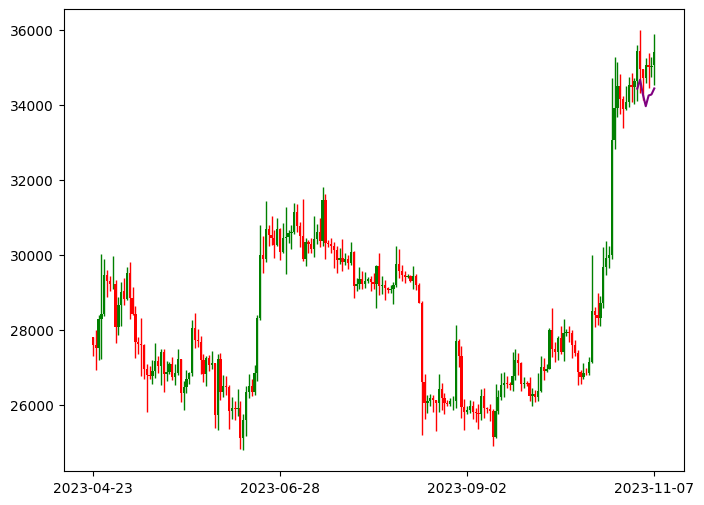

In [50]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0


for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set_return("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    try :
        final_dic_int_list = basic_seriealize(list_response)
    except :
        continue
    print("int list return")
    print(final_dic_int_list)
    
    final_dic = convert_return_to_close(final_dic_int_list, df_raw, input_length)
    print("int list, close")
    print(final_dic)

    index_save += 1
    plot_preds_candles(df_raw, train, test, final_dic, "gpt-4-vision-preview", show_samples=False, save_index = index_save)

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U1, U1, U1, U1, U1, U1, U1']
serialized :  [1, 1, 1, 1, 1, 1, 1]
int list, close
[[34987, 35336, 35689, 36045, 36405, 36769, 37136]]


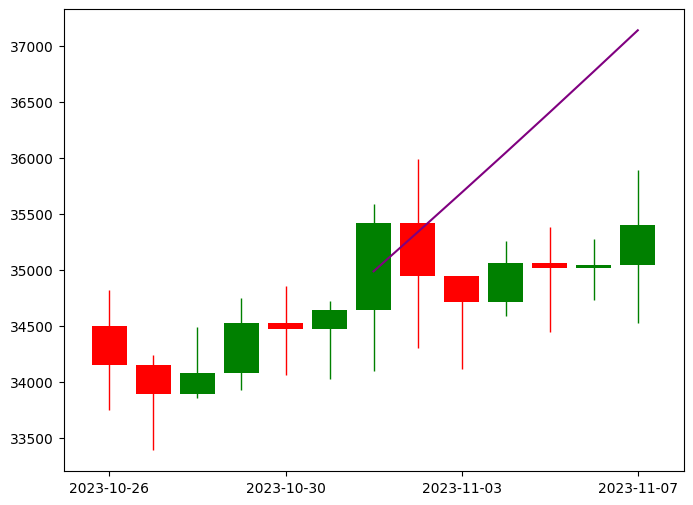

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D1, U1, D1, D2, D3, D4, D5']
serialized :  [-1, 1, -1, -2, -3, -4, -5]
int list, close
[[34294, 34636, 34289, 33603, 32594, 31290, 29725]]


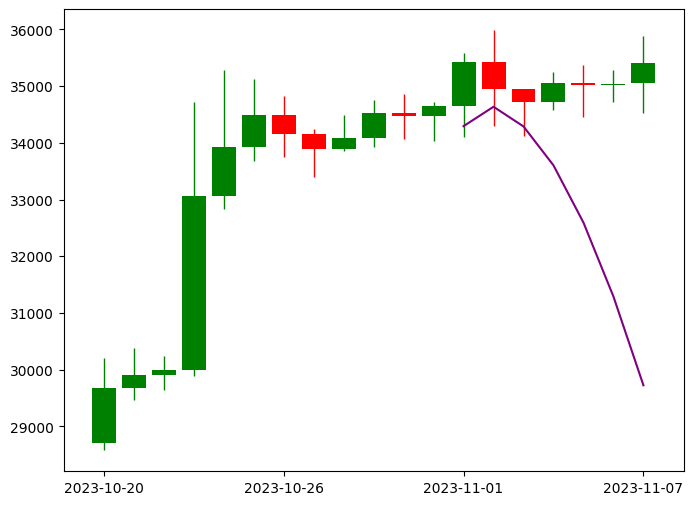

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D1, U1, D1, U1, D1, D1, U1']
serialized :  [-1, 1, -1, 1, -1, -1, 1]
int list, close
[[34294, 34636, 34289, 34631, 34284, 33941, 34280]]


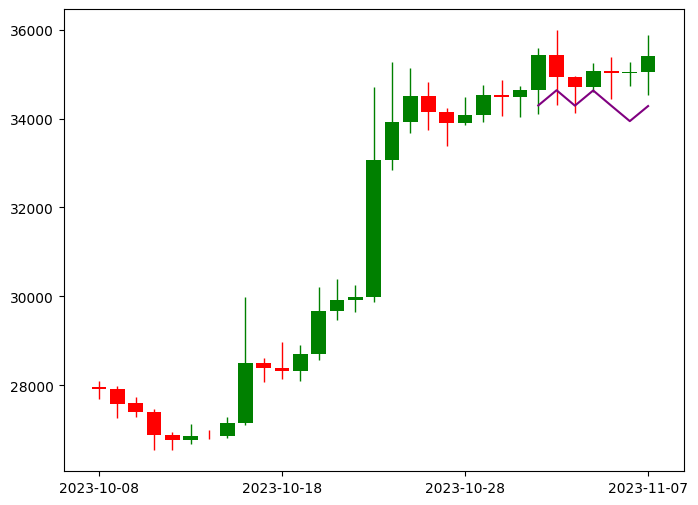

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D1, D2, D3, D2, D1, U1, U2']
serialized :  [-1, -2, -3, -2, -1, 1, 2]
int list, close
[[34294, 33608, 32599, 31947, 31627, 31943, 32581]]


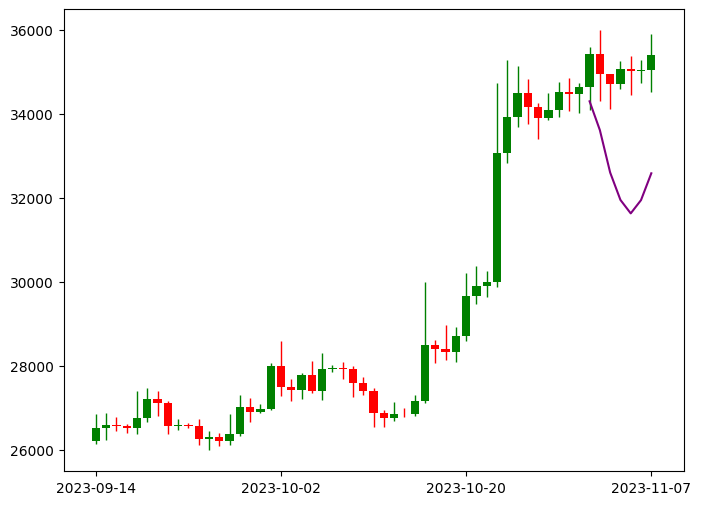

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U5+, U5+, D2, D3, U1, U5, U3']
serialized :  [6, 6, -2, -3, 1, 5, 3]
int list, close
[[36719, 38922, 38143, 36998, 37367, 39235, 40412]]


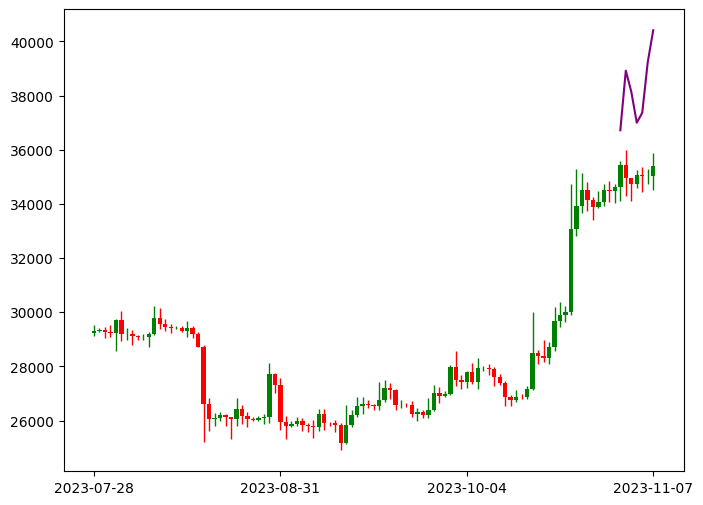

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

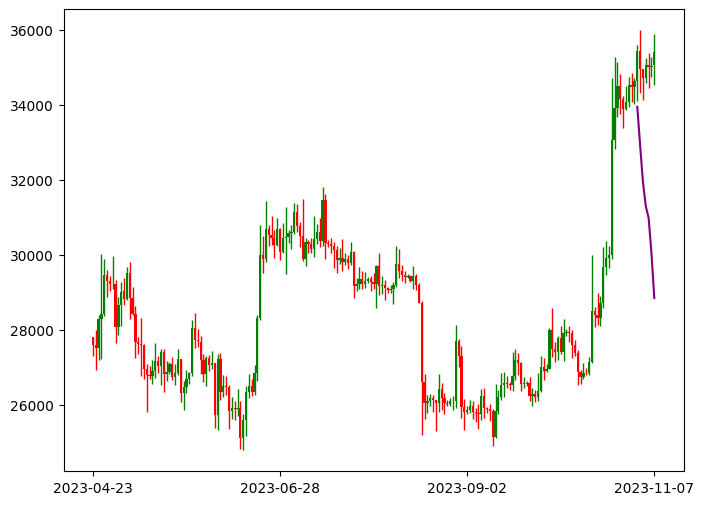

In [73]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0


for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt_bin(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = bin_seriealize(list_response)
    print("serialized : ", final_dic_int_list)

    final_dic = convert_bin_to_close(final_dic_int_list, df_raw, input_length)
    print("int list, close")
    print(final_dic)
    index_save += 1
    plot_preds_candles(df_raw, train, test, final_dic, "gpt-4-vision-preview", show_samples=False, save_index = index_save)


